# 🚥 대구 교통사고 피해 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
import pandas as pd
import numpy as np
import datetime
import random
import os
import sys
import holidays

In [ ]:
path1 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/train.csv'
path2 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/test.csv'
path3 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/sample_submission.csv'

In [ ]:
train = pd.read_csv(path1)
test = pd.read_csv(path2)
sub = pd.read_csv(path3)

## Data validation
- 유효성 검증 함수 생성

In [ ]:
def making_val_table(df):
    '''입력받은 데이터셋의 유효성 검증을 위한 요약 테이블'''
    # dtypes
    df_dtypes = df.dtypes

    # nunique
    df_nunique = df.nunique()

    # null_values
    df_nan = df.isna().sum()

    val_table = pd.concat([df_dtypes, df_nunique, df_nan], axis=1)
    val_table.columns = ['dtype', 'nunique', 'nan']

    return val_table.reset_index()

In [ ]:
# 기상상태, 시군구 데이터의 unique 값이 각각 7vs6, 199vs 192로 다르다
train_info = making_val_table(train)
test_info = making_val_table(test)

pd.merge(left=train_info, right=test_info, on='index',
         how='left', suffixes=('_train','_test')).set_index('index')

,dtype_train,nunique_train,nan_train,dtype_test,nunique_test,nan_test
index,,,,,,
ID,object,39609,0,object,10963.0,0.0
사고일시,object,18057,0,object,5548.0,0.0
요일,object,7,0,object,7.0,0.0
기상상태,object,6,0,object,5.0,0.0
시군구,object,199,0,object,192.0,0.0
도로형태,object,11,0,object,11.0,0.0
노면상태,object,6,0,object,6.0,0.0
사고유형,object,3,0,object,3.0,0.0
사고유형 - 세부분류,object,14,0,NaN,NaN,NaN


## Visualizing

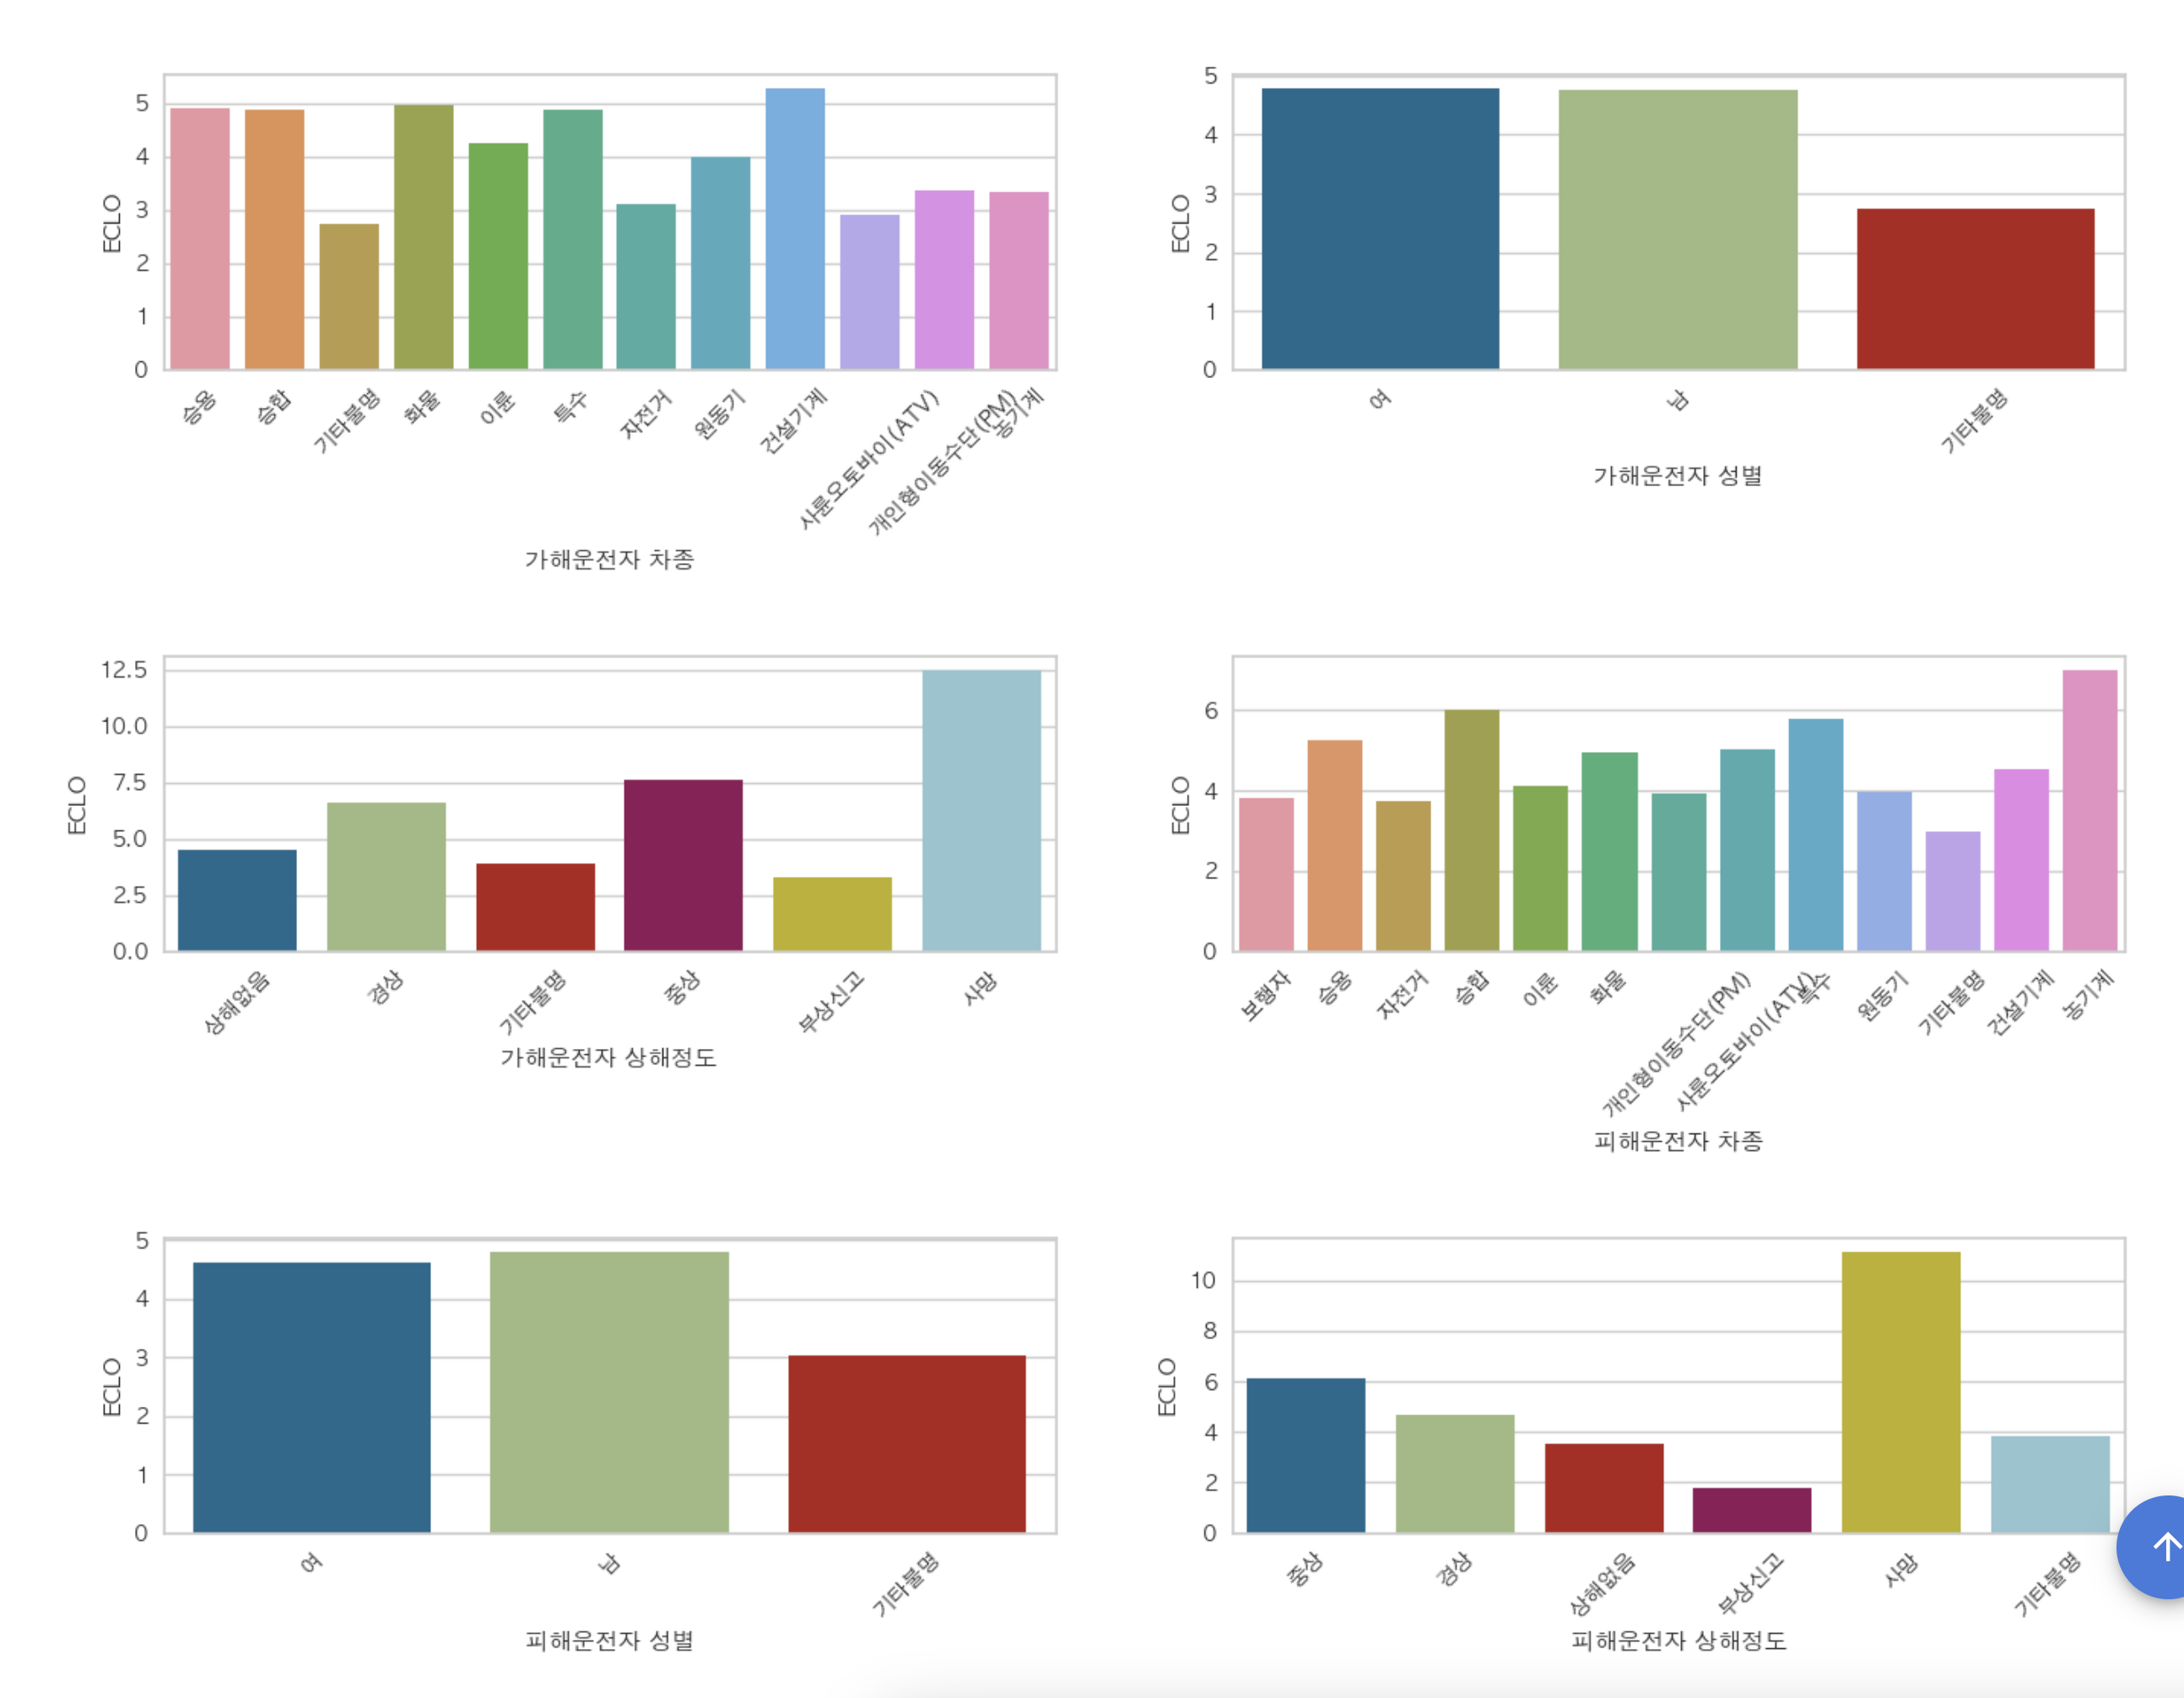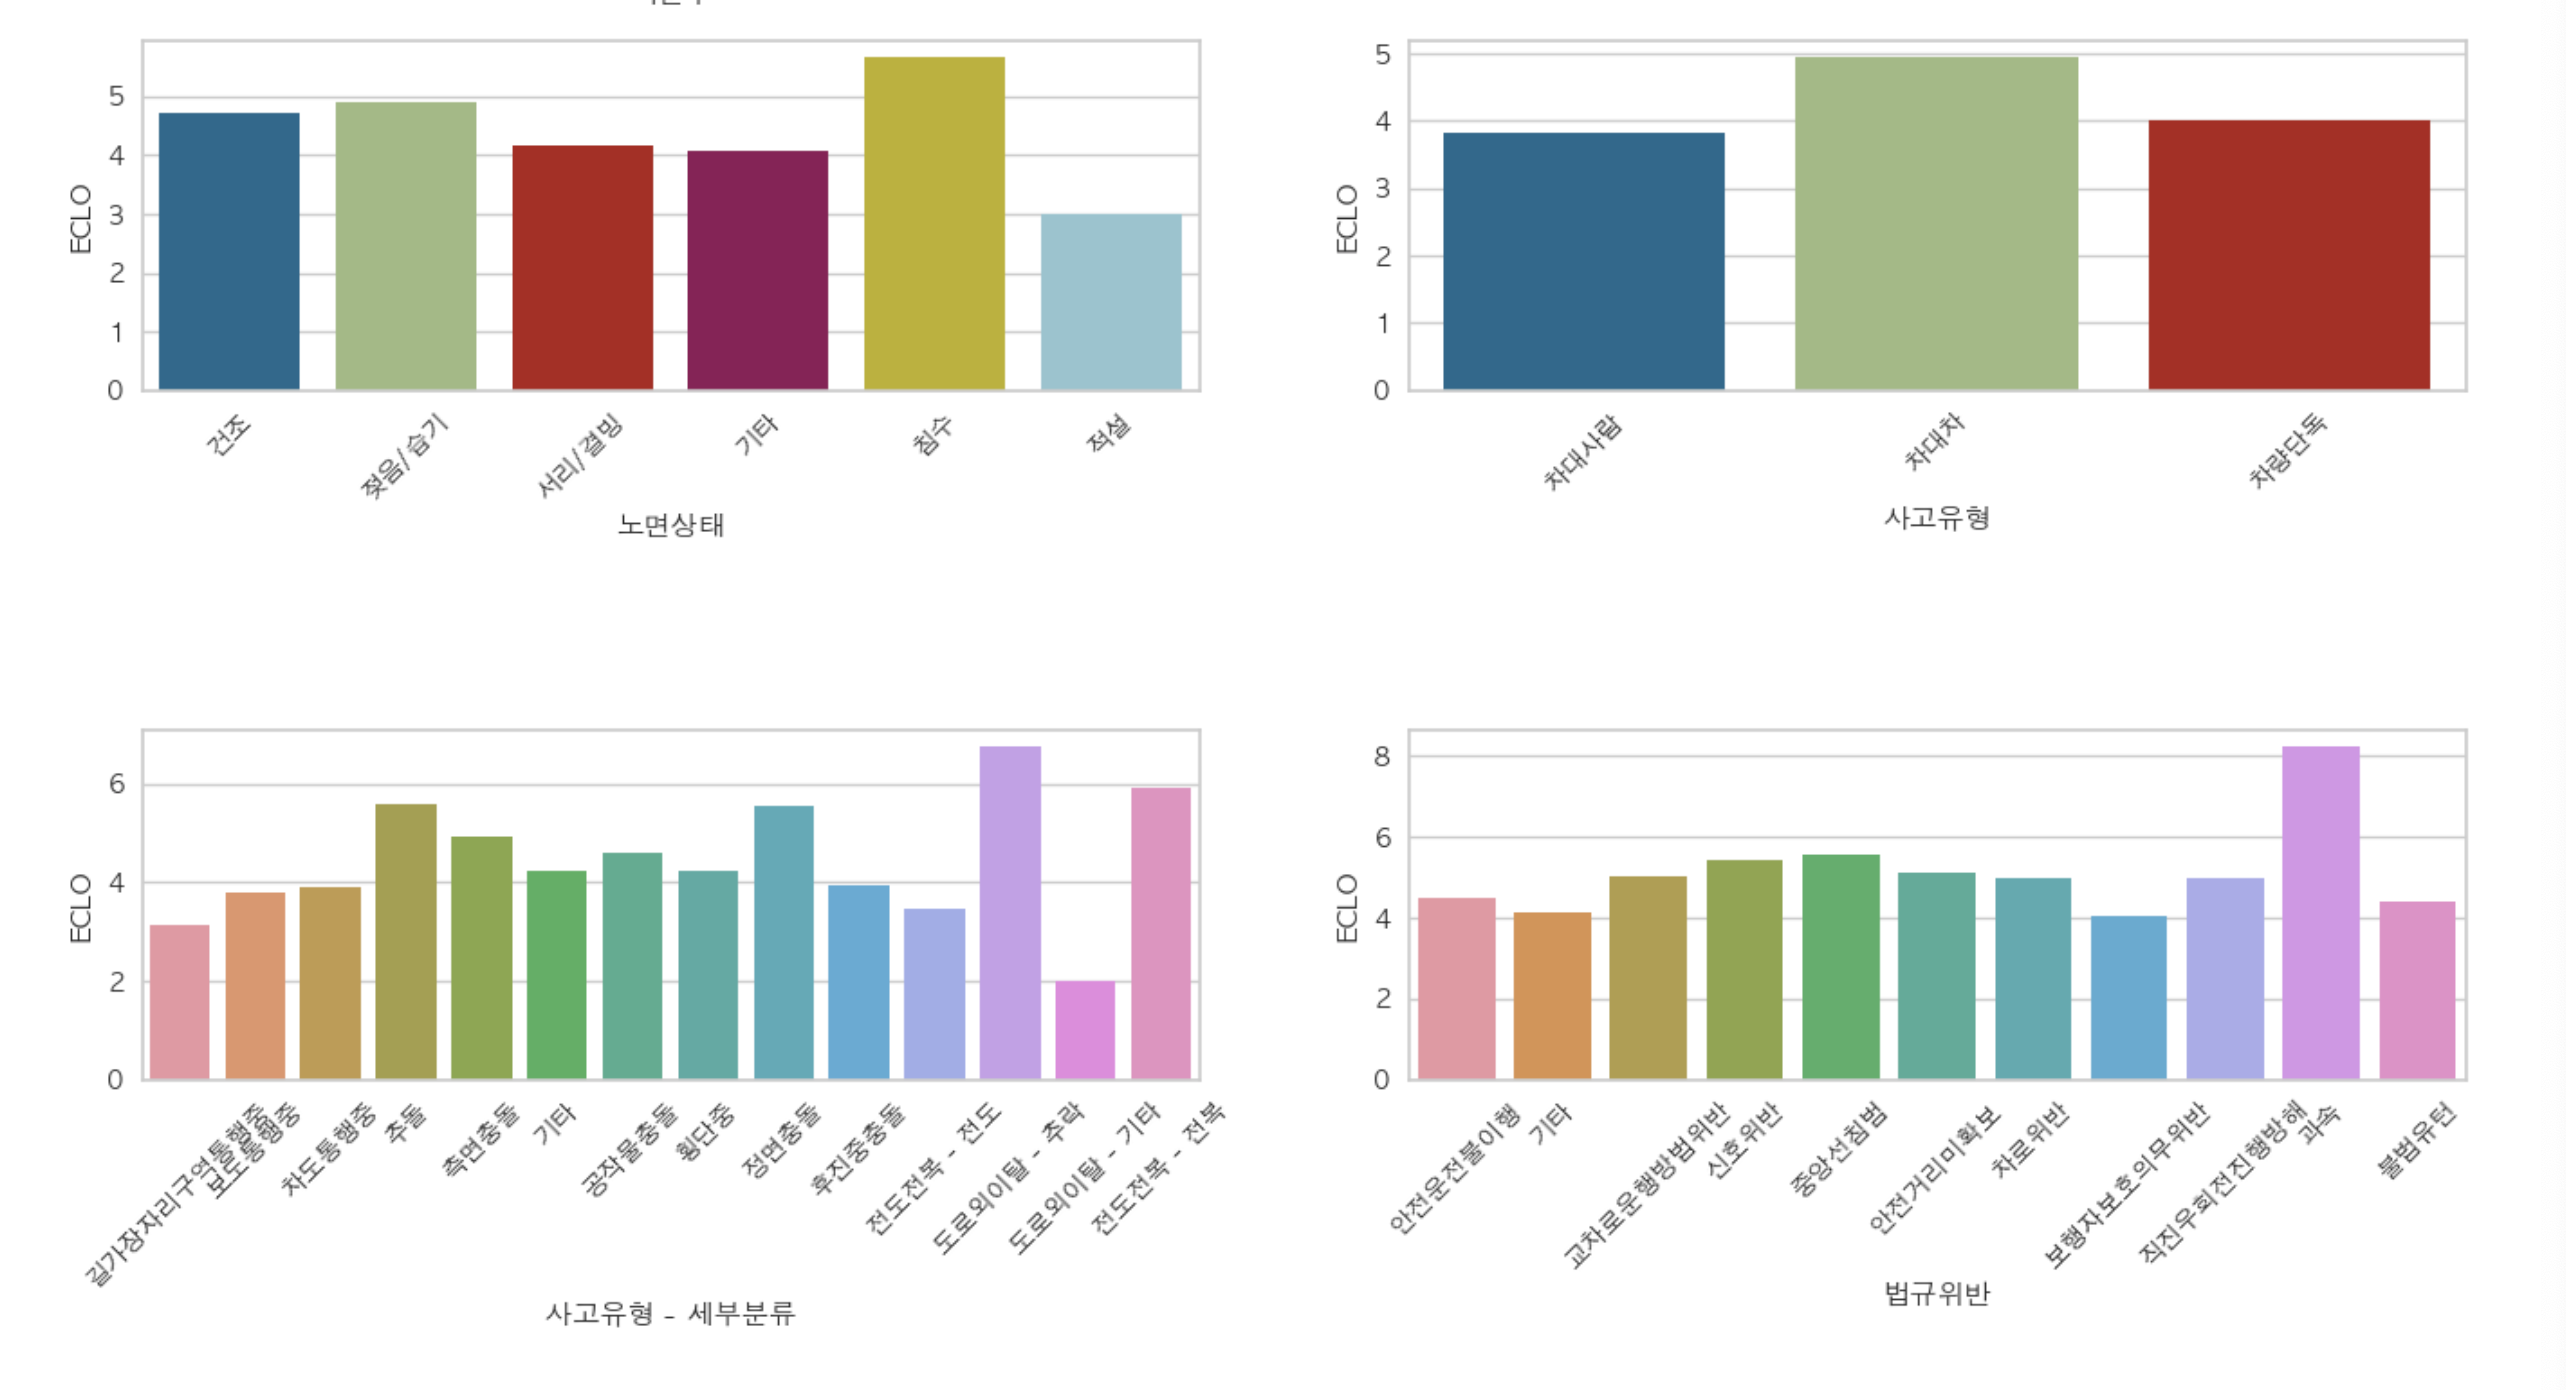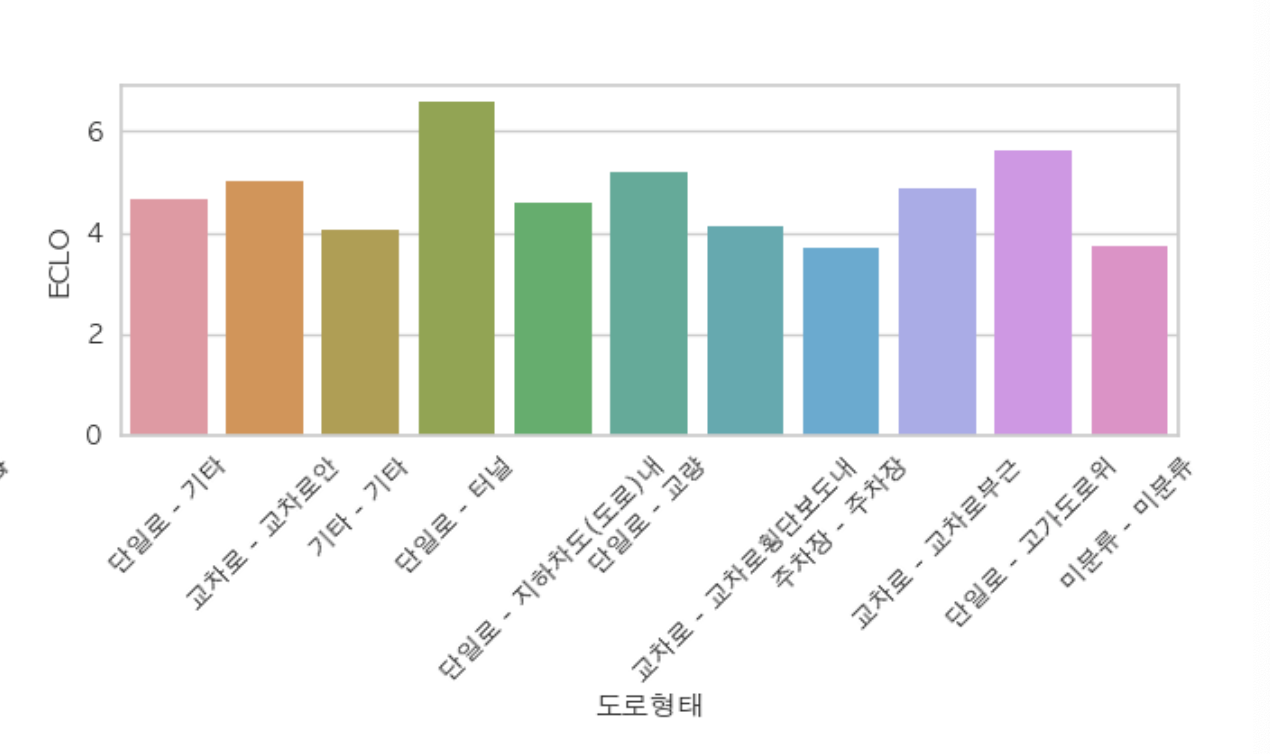

## 추가 제공 데이터 EDA

In [ ]:
path4 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/open/external_open/대구 보안등 정보.csv'
path5 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/open/external_open/대구 어린이 보호 구역 정보.csv'
path6 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/open/external_open/대구 주차장 정보.csv'

In [ ]:
light_df = pd.read_csv(path4, encoding='cp949')[['설치개수', '소재지지번주소']]
child_area_df = pd.read_csv(path5, encoding='cp949').drop_duplicates()[['소재지지번주소']]
parking_df = pd.read_csv(path6, encoding='cp949')[['소재지지번주소', '급지구분']]

<ipython-input-40-08eb1cadd19f>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  light_df = pd.read_csv(path4, encoding='cp949')[['설치개수', '소재지지번주소']]


### 보안등 Data 💡

In [ ]:
light_df

,설치개수,소재지지번주소
0,1,대구광역시 남구 대명동 1722-4
1,1,대구광역시 남구 대명동 1723-11
2,1,대구광역시 남구 대명동 1722-56
3,2,대구광역시 남구 대명동 1722-41
4,1,대구광역시 남구 대명동 1721-22
...,...,...
71908,1,대구광역시 중구 대봉동 165-9
71909,1,대구광역시 중구 대봉동 88-85
71910,1,대구광역시 중구 대봉동 719-20
71911,1,대구광역시 중구 대봉동 738-13


In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구' ,'동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소','번지'])
light_df

,설치개수,도시,구,동
0,1,대구광역시,남구,대명동
1,1,대구광역시,남구,대명동
2,1,대구광역시,남구,대명동
3,2,대구광역시,남구,대명동
4,1,대구광역시,남구,대명동
...,...,...,...,...
71908,1,대구광역시,중구,대봉동
71909,1,대구광역시,중구,대봉동
71910,1,대구광역시,중구,대봉동
71911,1,대구광역시,중구,대봉동


In [ ]:
#동별로 설치개수 합계 구하기
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)
light_df

,도시,구,동,설치개수
0,대구광역시,남구,대명동,5377
1,대구광역시,남구,봉덕동,1424
2,대구광역시,남구,이천동,556
3,대구광역시,달서구,갈산동,349
4,대구광역시,달서구,감삼동,932
...,...,...,...,...
223,대구광역시,중구,태평로2가,38
224,대구광역시,중구,태평로3가,47
225,대구광역시,중구,포정동,18
226,대구광역시,중구,향촌동,28


### 어린이 보호 구역 Data 🧒🏻 🚸

In [ ]:
child_area_df

,소재지지번주소
0,대구광역시 남구 대명동 1709
1,대구광역시 남구 이천동 477
2,대구광역시 남구 대명동 3050
3,대구광역시 남구 대명동 531-1
4,대구광역시 남구 대명동 960
...,...
635,대구광역시 중구 남산동 941-1
636,대구광역시 중구 봉산동 57
637,대구광역시 중구 남산동 153-2
638,대구광역시 중구 남산동 2623-6


In [ ]:
#갯수 컬럼 cnt 생성
child_area_df['cnt'] = 1

In [ ]:
child_area_df

,소재지지번주소,cnt
0,대구광역시 남구 대명동 1709,1
1,대구광역시 남구 이천동 477,1
2,대구광역시 남구 대명동 3050,1
3,대구광역시 남구 대명동 531-1,1
4,대구광역시 남구 대명동 960,1
...,...,...
635,대구광역시 중구 남산동 941-1,1
636,대구광역시 중구 봉산동 57,1
637,대구광역시 중구 남산동 153-2,1
638,대구광역시 중구 남산동 2623-6,1


In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])
child_area_df

,cnt,도시,구,동
0,1,대구광역시,남구,대명동
1,1,대구광역시,남구,이천동
2,1,대구광역시,남구,대명동
3,1,대구광역시,남구,대명동
4,1,대구광역시,남구,대명동
...,...,...,...,...
635,1,대구광역시,중구,남산동
636,1,대구광역시,중구,봉산동
637,1,대구광역시,중구,남산동
638,1,대구광역시,중구,남산동


In [ ]:
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)
child_area_df

,도시,구,동,cnt
0,대구광역시,남구,대명동,26
1,대구광역시,남구,봉덕동,8
2,대구광역시,남구,이천동,6
3,대구광역시,달성군,가창면,4
4,대구광역시,달성군,구지면,3
...,...,...,...,...
66,대구광역시,중구,봉산동,2
67,대구광역시,중구,삼덕동2가,1
68,대구광역시,중구,삼덕동3가,1
69,대구광역시,중구,서문로1가,1


### 주차구역 Data 🚙

In [ ]:
parking_df

,소재지지번주소,급지구분
0,대구광역시 남구 봉덕동 1002-69,1
1,대구광역시 남구 봉덕동 687-8,1
2,대구광역시 남구 대명동 1803-10,1
3,대구광역시 남구 봉덕동 1256,2
4,대구광역시 남구 봉덕동 976-5,1
...,...,...
866,대구광역시 중구 동인동1가 330-8,1
867,대구광역시 중구 수창동 95-1,1
868,대구광역시 중구 봉산동 38-2,1
869,대구광역시 중구 삼덕동2가 246,1


In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df

,도시,구,동,급지구분
0,대구광역시,남구,대명동,22
1,대구광역시,남구,봉덕동,15
2,대구광역시,남구,이천동,3
3,대구광역시,달서구,갈산동,12
4,대구광역시,달서구,감삼동,11
...,...,...,...,...
131,대구광역시,중구,태평로2가,5
132,대구광역시,중구,태평로3가,1
133,대구광역시,중구,포정동,4
134,대구광역시,중구,향촌동,2


## Train | Test data Preprocessing

In [ ]:
path1 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/train.csv'
path2 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/test.csv'
path3 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/sample_submission.csv'

In [ ]:
train = pd.read_csv(path1)
test = pd.read_csv(path2)
sub = pd.read_csv(path3)

In [ ]:
print(train.columns)
print(test.columns)

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')
Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')


In [ ]:
train_df = train.copy()
test_df = test.copy()


train_df['사고일시']= train['사고일시'].astype('str')
test_df['사고일시'] = test['사고일시'].astype('str')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [ ]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

In [ ]:
#TRAIN
#년/월/일 추가
train_df['연']=train_df['사고일시'].dt.year
train_df['월']=train_df['사고일시'].dt.month
train_df['일']=train_df['사고일시'].dt.day
train_df['시간']=train_df['사고일시'].dt.hour

# 주차 변수 추가
train_df["주차"] = train_df["사고일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

# 주차 누적값
week_list=[]
for i in range(len(train_df['연'])) :
    if train_df['연'][i] == 2019 :
        week_list.append(int(train_df['주차'][i]))
    elif train_df['연'][i] == 2020 :
        week_list.append(int(train_df['주차'][i])+52)
    elif train_df['연'][i] == 2021 :
        week_list.append(int(train_df['주차'][i])+52+53)
    elif train_df['연'][i] == 2022 :
        week_list.append(int(train_df['주차'][i])+52+53+53)
    elif train_df['연'][i] == 2023 :
        week_list.append(int(train_df['주차'][i])+52+53+53+52)
train_df['n주차']= week_list

 # 공휴일 변수 추가
def make_holi(x):
    kr_holi = holidays.KR()

    if x in kr_holi:
        return 1
    else:
        return 0

train_df["휴일"] = train_df["사고일시"].map(lambda x : make_holi(x))

#TEST
test_df['연']=test_df['사고일시'].dt.year
test_df['월']=test_df['사고일시'].dt.month
test_df['일']=test_df['사고일시' ].dt.day
test_df['시간']=test_df['사고일시'].dt.hour

# 주차 변수 추가
test_df["주차"] = test_df["사고일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

# 주차 누적값
week_list=[]
for i in range(len(test_df['연'])) :
    if test_df['연'][i] == 2019 :
        week_list.append(int(test_df['주차'][i]))
    elif test_df['연'][i] == 2020 :
        week_list.append(int(test_df['주차'][i])+52)
    elif test_df['연'][i] == 2021 :
        week_list.append(int(test_df['주차'][i])+52+53)
    elif test_df['연'][i] == 2022 :
        week_list.append(int(test_df['주차'][i])+52+53+53)
    elif test_df['연'][i] == 2023 :
        week_list.append(int(test_df['주차'][i])+52+53+53+52)
test_df['n주차']= week_list

 # 공휴일 변수 추가
def make_holi(x):
    kr_holi = holidays.KR()

    if x in kr_holi:
        return 1
    else:
        return 0

test_df["휴일"] = test_df["사고일시"].map(lambda x : make_holi(x))

In [ ]:
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

### Merge

In [ ]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [ ]:
print(f"전처리 후 train 크기 : {train_df.shape}")
print(f"전처리 후 test 크기 : {test_df.shape}")

전처리 후 train 크기 : (39609, 35)
전처리 후 test 크기 : (10963, 20)


In [ ]:
train_df.rename(columns={'설치개수':'보안등', 'cnt':'어린이보호구역', '급지구분':'주차구역'}, inplace=True)
test_df.rename(columns={'설치개수':'보안등', 'cnt':'어린이보호구역', '급지구분':'주차구역'}, inplace=True)

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '주차', 'n주차', '휴일', '도시', '구', '동', '도로형태1', '도로형태2',
       '보안등', '어린이보호구역', '주차구역'],
      dtype='object')

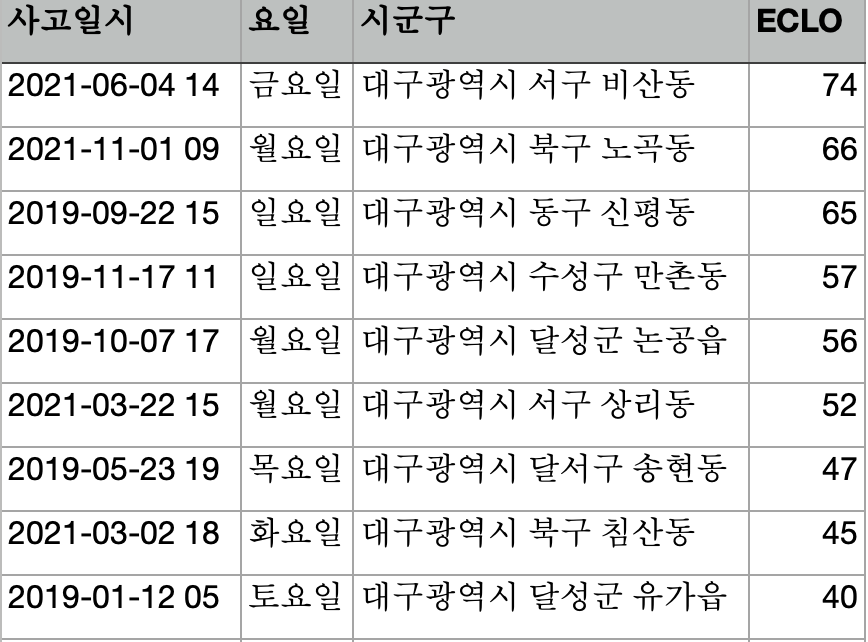

In [ ]:
#극 이상치 제거
train_df_idx = train_df[(train_df["ECLO"]>=40)].index

train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="비산동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="노곡동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="신평동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="만촌동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="논공읍")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="상리동")]["ECLO"].mean()

train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="송현동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="침산동")]["ECLO"].mean()
train_df.loc[train_df_idx,"ECLO"] = train_df[(train_df["동"]=="유가읍")]["ECLO"].mean()

In [ ]:
train_df.to_csv('train_p.csv',index=False)
test_df.to_csv('test_p.csv',index=False)

## Feature Engineering

In [ ]:
train_df = pd.read_csv('train_p.csv')
test_df = pd.read_csv('test_p.csv')

In [ ]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '주차', 'n주차',
       '휴일', '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', 'cnt', '급지구분'],
      dtype='object')

In [ ]:
col = ['요일','기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '주차', 'n주차',
       '휴일', '도시', '구', '동', '도로형태1', '도로형태2', '보안등', '어린이보호구역', '주차구역']

test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[col].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,주차,n주차,휴일,도시,구,동,도로형태1,도로형태2,보안등,어린이보호구역,주차구역
0,4.621314,4.702668,4.704367,3.817650,2019,1,1,0,1,1,1,4.715206,4.541610,4.282449,4.657598,4.586181,391.0,2.0,11.0
1,4.621314,4.779150,4.704367,3.817650,2019,1,1,0,1,1,1,4.715206,4.614213,4.738938,4.657598,4.586181,932.0,NaN,11.0
2,4.621314,4.702668,4.704367,3.817650,2019,1,1,1,1,1,1,4.715206,4.719573,4.842715,4.657598,4.586181,473.0,5.0,NaN
3,4.621314,4.702668,4.704367,4.932151,2019,1,1,2,1,1,1,4.715206,4.672534,4.208920,4.657598,4.586181,534.0,11.0,33.0
4,4.621314,4.702668,4.704367,4.932151,2019,1,1,4,1,1,1,4.715206,4.878333,4.549091,4.657598,4.586181,2057.0,NaN,2.0


,요일,기상상태,노면상태,사고유형,연,월,일,시간,주차,n주차,휴일,도시,구,동,도로형태1,도로형태2,보안등,어린이보호구역,주차구역
0,4.91467,4.702668,4.704367,3.817650,2022,1,1,1,52,210,1,4.715206,4.719573,4.881657,4.872527,5.002636,700.0,5.0,NaN
1,4.91467,4.702668,4.704367,3.817650,2022,1,1,1,52,210,1,4.715206,4.719573,4.563008,4.657598,4.586181,NaN,10.0,6.0
2,4.91467,4.702668,4.704367,4.932151,2022,1,1,4,52,210,1,4.715206,4.719573,4.945578,4.872527,5.002636,NaN,1.0,NaN
3,4.91467,4.702668,4.704367,4.932151,2022,1,1,4,52,210,1,4.715206,4.719573,4.438172,4.657598,4.586181,NaN,7.0,7.0
4,4.91467,4.702668,4.704367,4.932151,2022,1,1,6,52,210,1,4.715206,4.614213,4.738938,4.872527,5.002636,932.0,NaN,11.0


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

## tensorflow Dense Modeling

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100, batch_size=28,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1274/1274 [==============================] - 4s 505us/step - loss: nan - metric_fn: nan - val_loss: nan - val_metric_fn: nan - lr: 0.0010


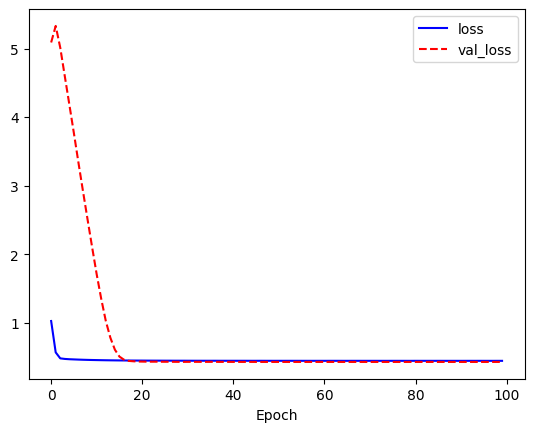

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


- train_loss(노란색) : 훈련 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
- val_loss(빨간색) : 검증 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
- train_acc(파란색) : 훈련 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.
- val_acc(녹색) : 검증 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.

In [ ]:
sub["ECLO"] = model.predict(test_x.astype('float32'))
sub.to_csv("tensorflow_Dense_Model_이상치제거.csv", index=False)
sub

343/343 [==============================] - 2s 6ms/step


,ID,ECLO
0,ACCIDENT_39609,2.131662
1,ACCIDENT_39610,2.201259
2,ACCIDENT_39611,3.934963
3,ACCIDENT_39612,3.613853
4,ACCIDENT_39613,3.949470
...,...,...
10958,ACCIDENT_50567,6.086650
10959,ACCIDENT_50568,4.389957
10960,ACCIDENT_50569,4.740364
10961,ACCIDENT_50570,4.626708


에포크 100 + 전처리(시간,공휴일 변수 추가)
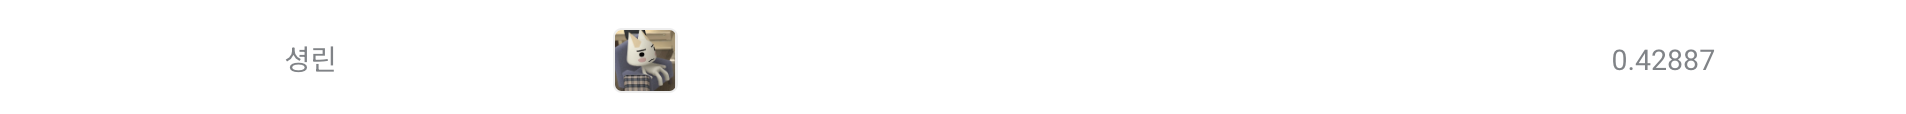

에포크 200
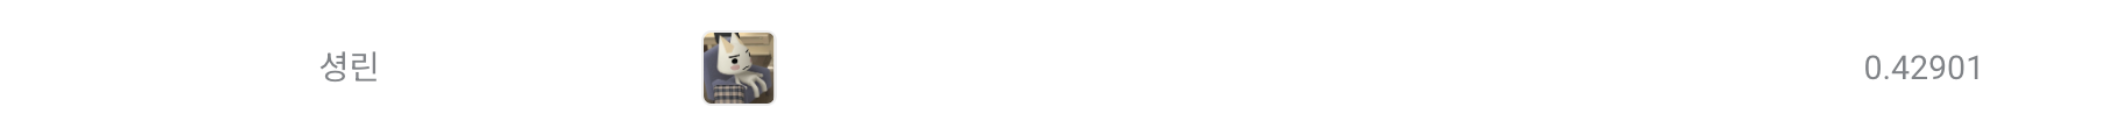

에포크 100
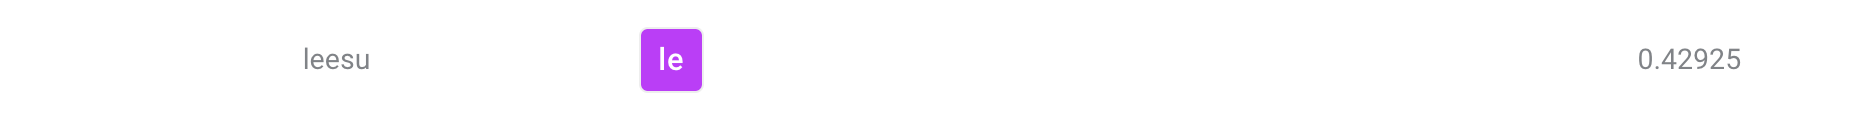

--------

## Catboost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
train_df = pd.read_csv('train_p.csv').drop(columns = 'ID') #2019-2021
test_df = pd.read_csv('test_p.csv').drop(columns = 'ID') #2022

In [ ]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,주차,n주차,휴일,도시,구,동,도로형태1,도로형태2,보안등,어린이보호구역,주차구역
0,토요일,맑음,건조,차대사람,2022,1,1,1,52,210,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN
1,토요일,맑음,건조,차대사람,2022,1,1,1,52,210,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,6.0
2,토요일,맑음,건조,차대차,2022,1,1,4,52,210,1,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN
3,토요일,맑음,건조,차대차,2022,1,1,4,52,210,1,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,7.0
4,토요일,맑음,건조,차대차,2022,1,1,6,52,210,1,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,토요일,맑음,건조,차대차,2022,12,31,18,52,210,0,대구광역시,남구,대명동,단일로,터널,5377.0,26.0,22.0
10959,토요일,맑음,건조,차대차,2022,12,31,18,52,210,0,대구광역시,수성구,시지동,단일로,기타,NaN,5.0,NaN
10960,토요일,맑음,건조,차대차,2022,12,31,20,52,210,0,대구광역시,수성구,연호동,단일로,기타,NaN,NaN,NaN
10961,토요일,맑음,건조,차대차,2022,12,31,20,52,210,0,대구광역시,수성구,범물동,교차로,교차로부근,NaN,7.0,NaN


In [ ]:
X = train_df[test_df.columns].copy()
y = train_df['ECLO'].copy()

In [ ]:
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   요일       39609 non-null  object 
 1   기상상태     39609 non-null  object 
 2   노면상태     39609 non-null  object 
 3   사고유형     39609 non-null  object 
 4   연        39609 non-null  int64  
 5   월        39609 non-null  int64  
 6   일        39609 non-null  int64  
 7   시간       39609 non-null  int64  
 8   주차       39609 non-null  int64  
 9   n주차      39609 non-null  int64  
 10  휴일       39609 non-null  int64  
 11  도시       39609 non-null  object 
 12  구        39609 non-null  object 
 13  동        39609 non-null  object 
 14  도로형태1    39609 non-null  object 
 15  도로형태2    39609 non-null  object 
 16  보안등      39609 non-null  float64
 17  어린이보호구역  39609 non-null  float64
 18  주차구역     39609 non-null  float64
dtypes: float64(3), int64(7), object(9)
memory usage: 5.7+ MB


In [ ]:
X['보안등'] = X['보안등'].astype(int)
X['어린이보호구역'] = X['어린이보호구역'].astype(int)
X['주차구역'] = X['주차구역'].astype(int)

test_df['보안등'] = test_df['보안등'].astype(int)
test_df['어린이보호구역'] = test_df['어린이보호구역'].astype(int)
test_df['주차구역'] = test_df['주차구역'].astype(int)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   요일       10963 non-null  object
 1   기상상태     10963 non-null  object
 2   노면상태     10963 non-null  object
 3   사고유형     10963 non-null  object
 4   연        10963 non-null  int64 
 5   월        10963 non-null  int64 
 6   일        10963 non-null  int64 
 7   시간       10963 non-null  int64 
 8   주차       10963 non-null  int64 
 9   n주차      10963 non-null  int64 
 10  휴일       10963 non-null  int64 
 11  도시       10963 non-null  object
 12  구        10963 non-null  object
 13  동        10963 non-null  object
 14  도로형태1    10963 non-null  object
 15  도로형태2    10963 non-null  object
 16  보안등      10963 non-null  int64 
 17  어린이보호구역  10963 non-null  int64 
 18  주차구역     10963 non-null  int64 
dtypes: int64(10), object(9)
memory usage: 1.6+ MB


In [ ]:
# 모델 학습
model = CatBoostRegressor(random_state = 2024,
                            n_estimators = 1000,
                            learning_rate = 0.01,
                            depth = 10,
                            l2_leaf_reg = 3,
                            metric_period = 1000)
model.fit(X, y, verbose=1,cat_features=X.columns.tolist())

# 모델 학습
y_pred = model.predict(test_df)

0:	learn: 3.1085929	total: 410ms	remaining: 6m 49s
999:	learn: 2.9346564	total: 7m 8s	remaining: 0us


In [ ]:
baseline_submission = sub.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission.to_csv('Catboost.csv', index=False)
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.325624
1,ACCIDENT_39610,3.902641
2,ACCIDENT_39611,5.924940
3,ACCIDENT_39612,4.992659
4,ACCIDENT_39613,5.206610
...,...,...
10958,ACCIDENT_50567,4.997550
10959,ACCIDENT_50568,5.011855
10960,ACCIDENT_50569,5.224284
10961,ACCIDENT_50570,5.274827


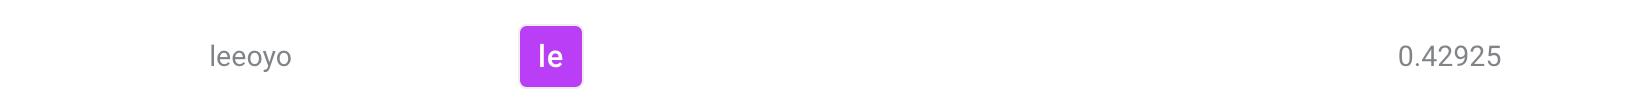

## Autogluon

In [ ]:
!pip install autogluon

In [ ]:
train_df = pd.read_csv('train_p.csv').drop(columns = 'ID') #2019-2021 전처리한 데이터
test_df = pd.read_csv('test_p.csv').drop(columns = 'ID') #2022 전처리한 데이터

In [ ]:
test_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '주차', 'n주차', '휴일',
       '도시', '구', '동', '도로형태1', '도로형태2', '보안등', '어린이보호구역', '주차구역'],
      dtype='object')

In [ ]:
cols = ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '주차', 'n주차', '휴일',
       '도시', '구', '동', '도로형태1', '도로형태2', '보안등', '어린이보호구역', '주차구역','ECLO']
train_df = train_df[cols]

In [ ]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_df = TabularDataset(train_df)
test_df = TabularDataset(test_df)

predictor = TabularPredictor(label = 'ECLO', problem_type = 'regression', eval_metric = 'rmse')


predictor.fit(train_data = train_df, presets = 'best_quality', time_limit = 60*60*6,
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 20, num_bag_sets = 30, num_stack_levels = 3,
              num_gpus = 1, num_cpus = 8, verbosity = 2)

No path specified. Models will be saved in: "AutogluonModels/ag-20231122_132403/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=20, num_bag_sets=30
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "AutogluonModels/ag-20231122_132403/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   206.87 GB / 242.49 GB (85.3%)
Train Data Rows:    39609
Train Data Columns: 19
Label Column: ECLO
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11330.99 MB
	Train Data (Original)  Memory Usage: 34.55 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 

In [ ]:
path3 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/sample_submission.csv'
sub = pd.read_csv(path3)

pred = predictor.predict(test_df)
sub['ECLO'] = pred
sub.to_csv('dg_autogluon.csv', index = False)
display(sub)

,ID,ECLO
0,ACCIDENT_39609,4.394365
1,ACCIDENT_39610,4.126494
2,ACCIDENT_39611,5.459120
3,ACCIDENT_39612,5.094265
4,ACCIDENT_39613,5.040470
...,...,...
10958,ACCIDENT_50567,6.806462
10959,ACCIDENT_50568,4.968502
10960,ACCIDENT_50569,5.211134
10961,ACCIDENT_50570,5.180273


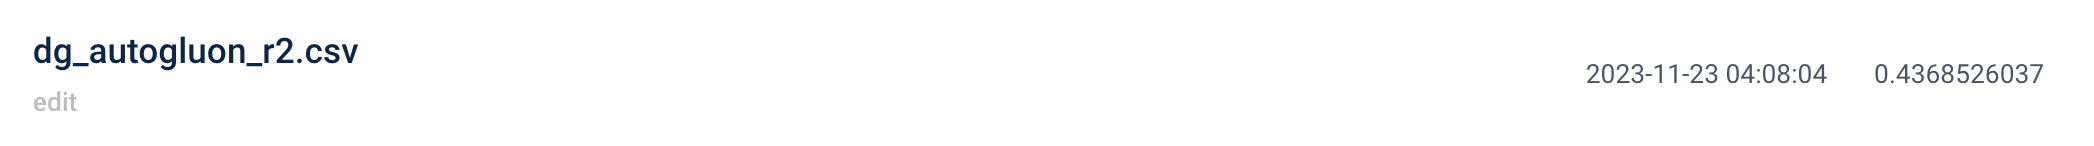